In [ ]:
%pip install datasets nltk

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from nltk.stem.porter import PorterStemmer
import nltk
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv")

In [ ]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [ ]:
print(df.head())

   count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


In [ ]:
df['label'] = df['class'].map({0: 'hate_speech', 1: 'offensive', 2: 'neither'})

In [ ]:
df['text_len'] = df['tweet'].apply(len)

<ipython-input-106-741fddcaf668>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["label"], palette="viridis")


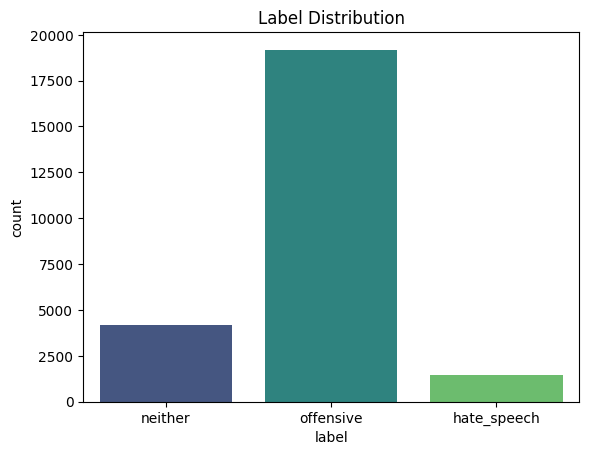

In [ ]:
sns.countplot(x=df["label"], palette="viridis")
plt.title("Label Distribution")
plt.show()

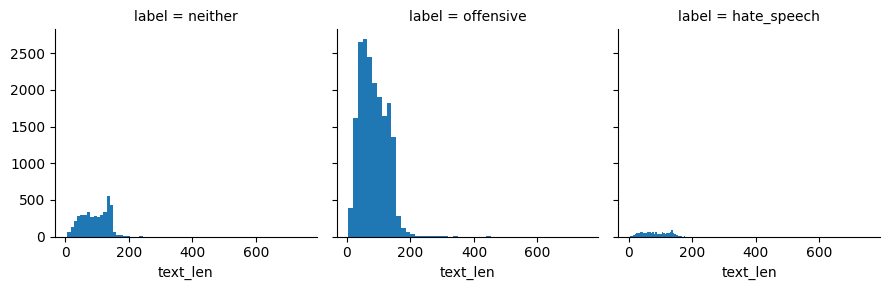

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=df, col='label')
graph.map(plt.hist, 'text_len', bins=50)

<Axes: xlabel='class', ylabel='text_len'>

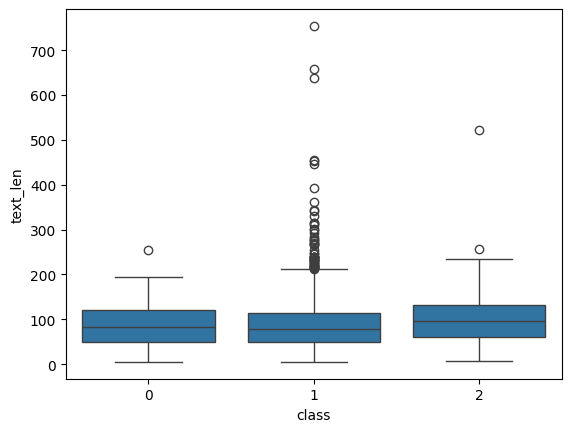

In [ ]:
sns.boxplot(x='class', y='text_len', data=df)

<Axes: >

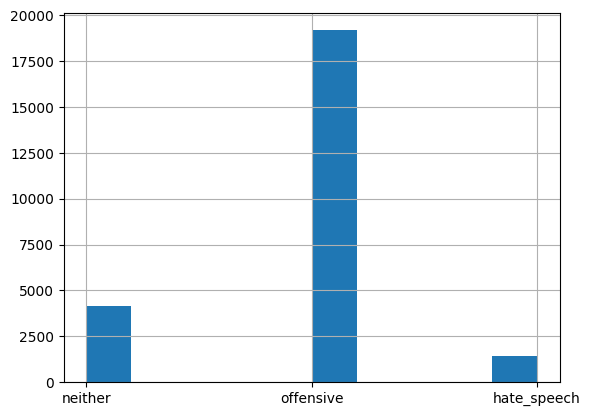

In [ ]:
df['label'].hist()

<ipython-input-110-008132a12538>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['label'] == 'hate_speech']['text_len'], label='Hate Speech', shade=True, color='red')
<ipython-input-110-008132a12538>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['label'] == 'offensive']['text_len'], label='Offensive', shade=True, color='orange')
<ipython-input-110-008132a12538>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['label'] == 'neither']['text_len'], label='Neither', shade=True, color='green')


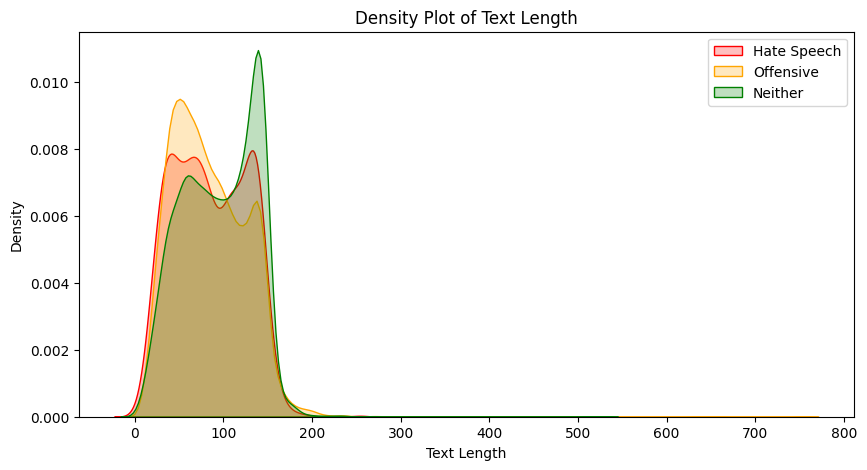

In [ ]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['label'] == 'hate_speech']['text_len'], label='Hate Speech', shade=True, color='red')
sns.kdeplot(df[df['label'] == 'offensive']['text_len'], label='Offensive', shade=True, color='orange')
sns.kdeplot(df[df['label'] == 'neither']['text_len'], label='Neither', shade=True, color='green')
plt.title('Density Plot of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.legend()
plt.show()


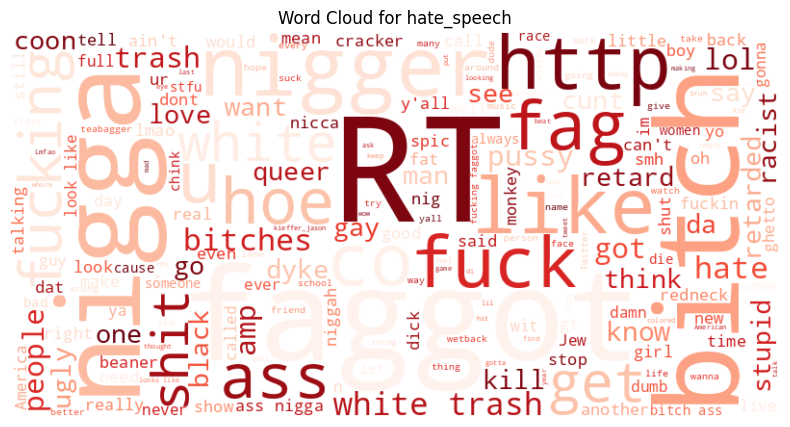

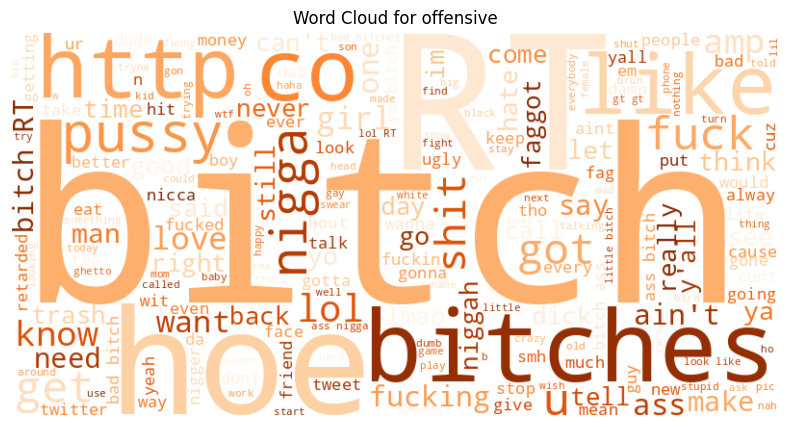

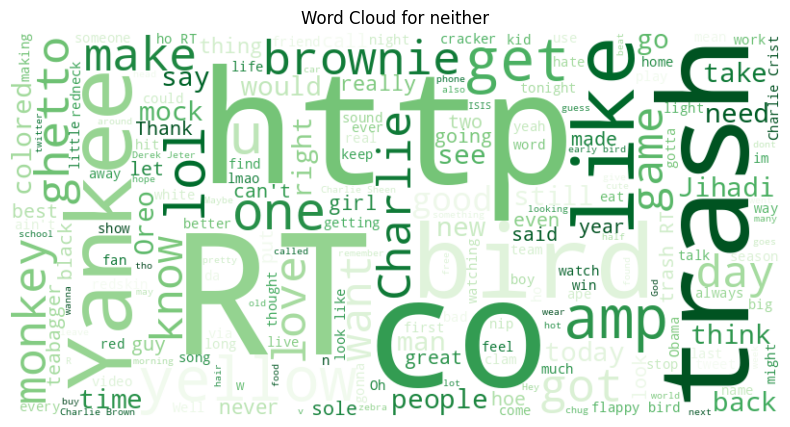

In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def plot_wordcloud(category, color):
    text = ' '.join(df[df['label'] == category]['tweet'])
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', colormap=color, width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category}')
    plt.axis('off')
    plt.show()

# plot_wordcloud('hate_speech', 'Reds')
# plot_wordcloud('offensive', 'Oranges')
# plot_wordcloud('neither', 'Greens')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(category, ngram_range=(2,2), num=10):
    text = df[df['label'] == category]['tweet']
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    bow = vec.fit_transform(text)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:num]

    return words_freq

bigrams_hate = get_top_ngrams('hate_speech', (2,2))
trigrams_hate = get_top_ngrams('hate_speech', (3,3))

print("Top 10 Bigrams for Hate Speech:\n", bigrams_hate)
print("Top 10 Trigrams for Hate Speech:\n", trigrams_hate)


Top 10 Bigrams for Hate Speech:
 [('white trash', np.int64(62)), ('128514 128514', np.int64(49)), ('ass nigga', np.int64(23)), ('look like', np.int64(17)), ('bitch ass', np.int64(15)), ('fucking faggot', np.int64(11)), ('faggot ass', np.int64(10)), ('bitch nigga', np.int64(10)), ('looks like', np.int64(9)), ('fuck bitch', np.int64(8))]
Top 10 Trigrams for Hate Speech:
 [('128514 128514 128514', np.int64(23)), ('bitch ass nigga', np.int64(7)), ('nigga nigga nigga', np.int64(4)), ('creepy ass cracker', np.int64(3)), ('127850 127850 127850', np.int64(3)), ('128079 128079 128079', np.int64(3)), ('128077 128077 128077', np.int64(3)), ('da colored folk', np.int64(3)), ('happy birthday faggot', np.int64(3)), ('softestmuffin _tee13 torahblaze', np.int64(3))]


In [ ]:
def print_ngrams(ngrams, title):
    print(f"\n### {title} ###\n")
    for i, (phrase, freq) in enumerate(ngrams, 1):
        print(f"{i}. {phrase} ({freq})")

print_ngrams(bigrams_hate, "Top 10 Bigrams for Hate Speech")
print_ngrams(trigrams_hate, "Top 10 Trigrams for Hate Speech")



### Top 10 Bigrams for Hate Speech ###

1. white trash (62)
2. 128514 128514 (49)
3. ass nigga (23)
4. look like (17)
5. bitch ass (15)
6. fucking faggot (11)
7. faggot ass (10)
8. bitch nigga (10)
9. looks like (9)
10. fuck bitch (8)

### Top 10 Trigrams for Hate Speech ###

1. 128514 128514 128514 (23)
2. bitch ass nigga (7)
3. nigga nigga nigga (4)
4. creepy ass cracker (3)
5. 127850 127850 127850 (3)
6. 128079 128079 128079 (3)
7. 128077 128077 128077 (3)
8. da colored folk (3)
9. happy birthday faggot (3)
10. softestmuffin _tee13 torahblaze (3)


<ipython-input-114-031c4e4747df>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='sentiment', data=df, palette='coolwarm')


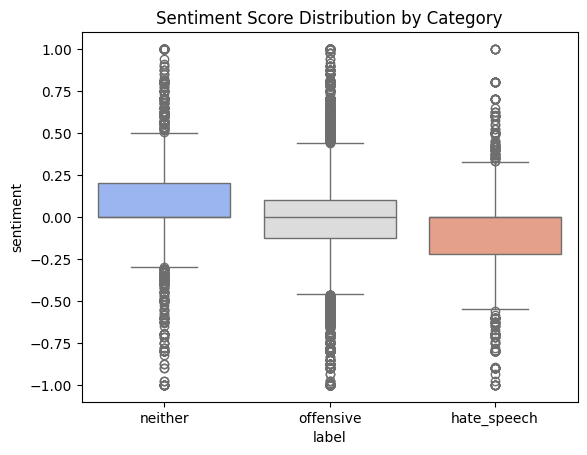

In [ ]:
from textblob import TextBlob

df['sentiment'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

sns.boxplot(x='label', y='sentiment', data=df, palette='coolwarm')
plt.title('Sentiment Score Distribution by Category')
plt.show()


In [ ]:
print(df)

       count  hate_speech  offensive_language  neither  class  \
0          3            0                   0        3      2   
1          3            0                   3        0      1   
2          3            0                   3        0      1   
3          3            0                   2        1      1   
4          6            0                   6        0      1   
...      ...          ...                 ...      ...    ...   
24778      3            0                   2        1      1   
24779      3            0                   1        2      2   
24780      3            0                   3        0      1   
24781      6            0                   6        0      1   
24782      3            0                   0        3      2   

                                                   tweet      label  text_len  \
0      !!! RT @mayasolovely: As a woman you shouldn't...    neither       140   
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba... 

In [ ]:
stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

In [ ]:
import re
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt_tab')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess(tweets):
    # Ensure input is a pandas Series
    if not isinstance(tweets, pd.Series):
        raise TypeError("Input must be a pandas Series")

    # Remove extra whitespace
    tweets = tweets.str.replace(r'\s+', ' ', regex=True)

    # Remove mentions (@username)
    tweets = tweets.str.replace(r'@[\w\-]+', '', regex=True)

    # Remove URLs
    tweets = tweets.str.replace(r'http[s]?://\S+', '', regex=True)

    # Remove punctuations except hashtags
    tweets = tweets.str.replace(r"[^a-zA-Z0-9#\s]", "", regex=True)

    # Replace numbers with 'numbr'
    tweets = tweets.str.replace(r'\d+(\.\d+)?', 'numbr', regex=True)

    # Convert to lowercase
    tweets = tweets.str.lower()

    # Tokenization
    tweets = tweets.apply(word_tokenize)

    # Lemmatization
    tweets = tweets.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    # Join tokens back into sentences
    tweets = tweets.apply(lambda x: ' '.join(x))

    return tweets

# Apply preprocessing to 'tweet' column
df['processed_tweets'] = preprocess(df['tweet'])


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df[["tweet","processed_tweets"]].head(10)

,tweet,processed_tweets
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt a a woman you shouldnt complain about clean...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dat coldtyga dwn bad for cuffin dat hoe...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitch and she start...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt she look like a tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me might be true or...
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",the shit just blow meclaim you so faithful and...
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",i can not just sit up and hate on another bitc...
7,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,# numbr cause im tired of you big bitch coming...
8,""" &amp; you might not get ya bitch back &amp; ...",amp you might not get ya bitch back amp thats ...
9,""" @rhythmixx_ :hobbies include: fighting Maria...",hobby include fighting mariam bitch


In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['processed_tweets'].tolist(), df['class'].tolist(), test_size=0.2, random_state=42
)


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [ ]:
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to("cuda")

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [ ]:
training_args = TrainingArguments(
    output_dir="./results", evaluation_strategy="epoch", save_strategy="epoch",
    num_train_epochs=1, per_device_train_batch_size=8, per_device_eval_batch_size=8,
    logging_dir="./logs", logging_steps=200
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset,
    eval_dataset=test_dataset, compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.261200,0.284709,0.909824,0.899816,0.896297,0.909824


TrainOutput(global_step=2479, training_loss=0.3205932603338256, metrics={'train_runtime': 1014.9864, 'train_samples_per_second': 19.533, 'train_steps_per_second': 2.442, 'total_flos': 2626345482061824.0, 'train_loss': 0.3205932603338256, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.2847086787223816,
 'eval_accuracy': 0.9098244906193262,
 'eval_f1': 0.8998155287266266,
 'eval_precision': 0.8962971425175601,
 'eval_recall': 0.9098244906193262,
 'eval_runtime': 73.6459,
 'eval_samples_per_second': 67.309,
 'eval_steps_per_second': 8.419,
 'epoch': 1.0}

In [ ]:
from datetime import datetime

# Get current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_path = f"./saved_model_{timestamp}"

# Save model and tokenizer
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model saved at: {save_path}")


Model saved at: ./saved_model_2025-03-18_19-40-31


In [ ]:
import torch

def predict(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    inputs = {key: value.to("cuda") for key, value in inputs.items()}
    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    label_map = {0: "hate_speech", 1: "offensive", 2: "neither"}
    return label_map[predicted_class]


In [ ]:
new_text = "grab them by their pussi"
prediction = predict(new_text, model, tokenizer)
print(f"Predicted label: {prediction}")

Predicted label: neither


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_texts)
X_test_tfidf = vectorizer.transform(test_texts)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, train_labels)

rf_predictions = rf_model.predict(X_test_tfidf)

In [ ]:
bert_predictions = trainer.predict(test_dataset).predictions.argmax(axis=-1)

def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    print(f"\n### {model_name} Evaluation ###")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("-" * 40)

evaluate_model(test_labels, bert_predictions, "BERT")
evaluate_model(test_labels, rf_predictions, "Random Forest")



### BERT Evaluation ###
Accuracy: 0.9098
Precision: 0.8963
Recall: 0.9098
F1-score: 0.8998
----------------------------------------

### Random Forest Evaluation ###
Accuracy: 0.8897
Precision: 0.8735
Recall: 0.8897
F1-score: 0.8757
----------------------------------------


In [ ]:
bert_eval_results = trainer.evaluate()

bert_accuracy = bert_eval_results['eval_accuracy']
bert_precision = bert_eval_results['eval_precision']
bert_recall = bert_eval_results['eval_recall']
bert_f1 = bert_eval_results['eval_f1']

In [ ]:
from sklearn.metrics import classification_report

rf_report = classification_report(test_labels, rf_predictions, output_dict=True)

rf_accuracy = rf_report['accuracy']
rf_precision = rf_report['weighted avg']['precision']
rf_recall = rf_report['weighted avg']['recall']
rf_f1 = rf_report['weighted avg']['f1-score']


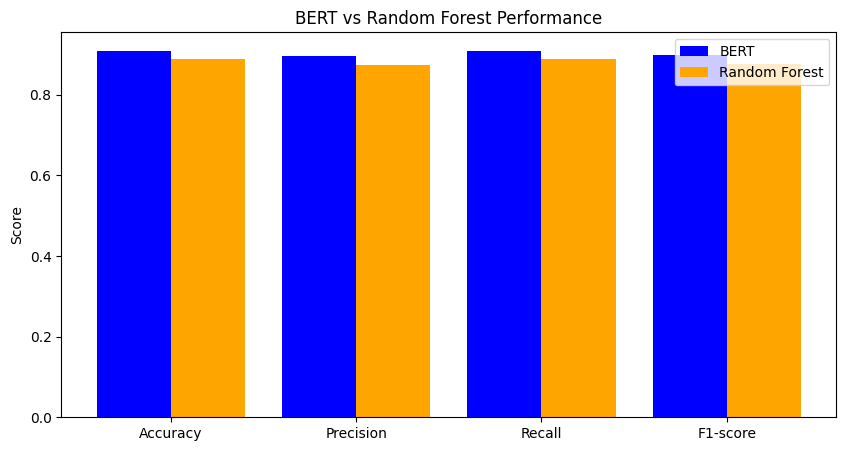

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
bert_values = [bert_accuracy, bert_precision, bert_recall, bert_f1]
rf_values = [rf_accuracy, rf_precision, rf_recall, rf_f1]

x = np.arange(len(metrics))

plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, bert_values, 0.4, label="BERT", color='blue')
plt.bar(x + 0.2, rf_values, 0.4, label="Random Forest", color='orange')
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("BERT vs Random Forest Performance")
plt.legend()
plt.show()


In [ ]:
test_sentences = [
    "y’all dumb as hell smh",  # Offensive
    "stfu nobody likes u",  # Offensive
    "y’all should just go back to where u came from",  # Hate Speech
    "people like you",  # Hate Speech
    "we don’t need ur kind here",  # Hate Speech

    "chilling today, no negativity 😊",  # Neither
    "hope y’all having a good day!",  # Neither
    "lol ggs y’all played well",  # Neither
    "man that was tough but we did it!",  # Neither
    "bro this song is fire 🔥",  # Neither
]



test_tfidf = vectorizer.transform(test_sentences)

from datasets import Dataset

tokenized_test_sentences = Dataset.from_dict({"text": test_sentences}).map(tokenize_function, batched=True)

bert_preds = trainer.predict(tokenized_test_sentences)
bert_labels = np.argmax(bert_preds.predictions, axis=1)

rf_preds = rf_model.predict(test_tfidf)

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

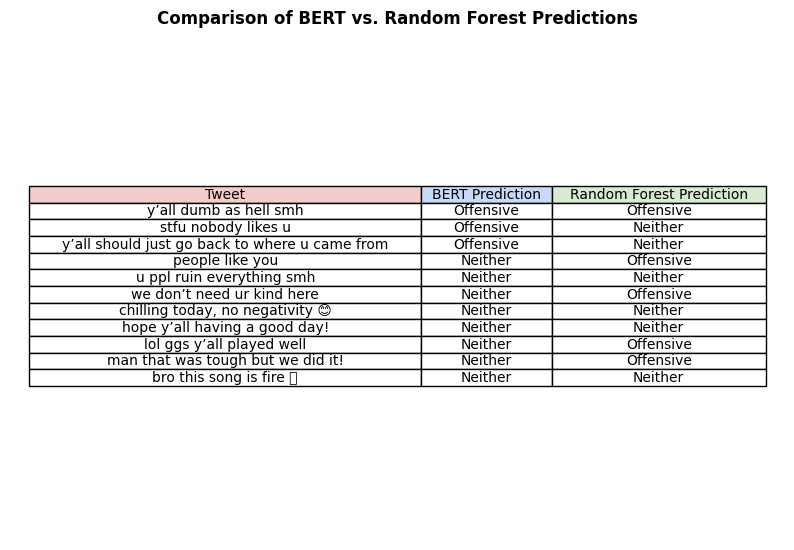

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

label_mapping = {0: "Hate Speech", 1: "Offensive", 2: "Neither"}

bert_human_labels = [label_mapping[label] for label in bert_labels]
rf_human_labels = [label_mapping[label] for label in rf_preds]

df_predictions = pd.DataFrame({
    "Tweet": test_sentences,
    "BERT Prediction": bert_human_labels,
    "Random Forest Prediction": rf_human_labels
})

fig, ax = plt.subplots(figsize=(10, len(test_sentences) * 0.6))
ax.axis("tight")
ax.axis("off")

table = ax.table(cellText=df_predictions.values, colLabels=df_predictions.columns,
                 cellLoc="center", loc="center", colColours=["#f4cccc", "#c9daf8", "#d9ead3"])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2])  # Adjust column width

plt.title("Comparison of BERT vs. Random Forest Predictions", fontsize=12, fontweight="bold")
plt.show()
